In [1]:
import datetime
import time

import pandas as pd
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
import pgpasslib

from querymsc import WorkflowTools

In [2]:
connection_string = "postgresql+psycopg2://nannau@dbmsc.pcic.uvic.ca/msc"
engine = create_engine(connection_string)
Session = sessionmaker(bind=engine)
session = Session()

In [3]:
start_time = datetime.datetime(1990, 1, 1)
end_time = datetime.datetime(2000, 1, 1)

msc = WorkflowTools(start_time, end_time, month=1)

In [4]:
annual_tot_precip = msc.query_annual_precip(session)
annual_tot_rain = msc.query_annual_rain(session)

Year interval: 10.0
Year interval: 10.0


In [5]:
start = time.time()
df_tot_precip = pd.read_sql(annual_tot_precip.statement, engine)
df_tot_rain = pd.read_sql(annual_tot_rain.statement, engine)
end = time.time()
print((end-start)/60., 'minutes', (end-start), 'seconds')

2.427764888604482 minutes 145.66589331626892 seconds


In [6]:
df_tot_precip.sort_values(by=['lon', 'lat']).head()

,sum,min_date,max_date,lat,lon,station_id
937,417.70,1990-01-01,2000-01-01,62.4103,-140.868,1778
828,282.97,1990-01-01,2000-01-01,67.5706,-139.839,1862
78,319.12,1990-01-01,2000-01-01,64.0431,-139.128,1803
1052,263.53,1990-01-01,2000-01-01,61.3667,-139.050,1789
121,352.64,1990-01-01,2000-01-01,65.3603,-138.305,1861


In [7]:
df_tot_rain.sort_values(by=['lon', 'lat']).head()

,sum,min_date,max_date,lat,lon,station_id
1130,295.82,1990-01-01,2000-01-01,62.4103,-140.868,1778
1150,162.51,1990-01-01,2000-01-01,67.5706,-139.839,1862
1139,186.05,1990-01-01,2000-01-01,64.0431,-139.128,1803
1124,180.43,1990-01-01,2000-01-01,61.3667,-139.050,1789
1145,212.59,1990-01-01,2000-01-01,65.3603,-138.305,1861


In [8]:
df_vars = pd.read_sql(msc.query_variables(session).statement, engine)
df_vars[df_vars['standard_name']=='lwe_thickness_of_precipitation_amount']

,vars_id,standard_name,long_description,unit,cell_method
72,1361,lwe_thickness_of_precipitation_amount,precipitation amount (minutes 00-60),0.1 mm,time: sum
73,1362,lwe_thickness_of_precipitation_amount,precipitation amount (minutes 00-15),0.1 mm,time: sum
74,1363,lwe_thickness_of_precipitation_amount,precipitation amount (minutes 15-30),0.1 mm,time: sum
75,1364,lwe_thickness_of_precipitation_amount,precipitation amount (minutes 30-45),0.1 mm,time: sum
76,1365,lwe_thickness_of_precipitation_amount,precipitation amount (minutes 45-60),0.1 mm,time: sum
108,1397,lwe_thickness_of_precipitation_amount,Total precipitation,0.1 mm,time: sum
119,1412,lwe_thickness_of_precipitation_amount,1200 UTC,0.1 mm,time: sum
120,1413,lwe_thickness_of_precipitation_amount,1800 UTC,0.1 mm,time: sum
121,1414,lwe_thickness_of_precipitation_amount,0000 UTC,0.1 mm,time: sum
122,1415,lwe_thickness_of_precipitation_amount,0600 UTC,0.1 mm,time: sum


In [9]:
df_vars[df_vars['standard_name'].str.contains('rain')]

,vars_id,standard_name,long_description,unit,cell_method
91,1380,thickness_of_rainfall_amount,Hourly rainfall,0.1 mm,time: sum
93,1382,rainfall_rate,5 minutes,0.1mm,
94,1383,rainfall_rate,10 minutes,0.1mm,
95,1384,rainfall_rate,15 minutes,0.1mm,
96,1385,rainfall_rate,30 minutes,0.1mm,
97,1386,rainfall_rate,1 hour,0.1mm,
98,1387,rainfall_rate,2 hours,0.1mm,
99,1388,rainfall_rate,6 hours,0.1mm,
100,1389,rainfall_rate,12 hours,0.1mm,
102,1391,rainfall_rate,24 hours,0.1mm,


In [14]:
df_wet_temp = pd.read_sql(msc.query_design_temp_25(session).statement, engine)

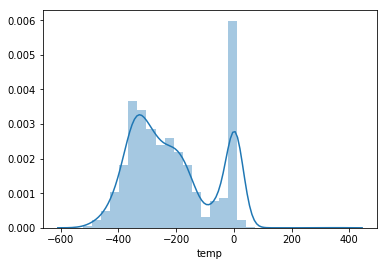

In [17]:
sns.distplot(df_wet_temp['temp'])

In [18]:
df_wet_temp

,temp,time_min,time_max,lat,lon,station_id
0,3.650,1990-01-02 00:00:00,1996-01-27 00:00:00,48.8667,-123.2830,6
1,3.800,1991-01-11 00:00:00,1995-01-31 00:00:00,48.4000,-123.4830,7
2,4.375,1990-01-02 00:00:00,1997-01-31 00:00:00,48.6000,-123.4670,12
3,2.000,1990-01-01 00:00:00,1994-01-25 00:00:00,48.5833,-123.4170,15
4,2.000,1990-01-02 00:00:00,1999-01-31 00:00:00,48.5733,-123.3920,16
5,-25.000,1991-01-09 00:00:00,2000-01-01 00:00:00,48.9350,-123.7420,18
6,6.000,1991-01-01 00:00:00,1994-01-24 00:00:00,48.6833,-123.6000,19
7,4.000,1990-01-01 00:00:00,1999-01-31 00:00:00,48.4178,-123.4810,22
8,-10.000,1990-01-01 00:00:00,1995-01-31 00:00:00,48.5167,-123.3670,25
9,2.000,1990-01-01 00:00:00,2000-01-01 00:00:00,48.7111,-123.5570,27
